In [65]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from warnings import simplefilter
simplefilter('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

In [66]:
# set matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize = (11,4), autolayout = True, titlesize = 10, titleweight = 'bold')
plt.rc('axes', titlesize =10, titleweight = 'bold', titlepad = 10, labelsize = 'large', labelweight = 'bold')
plot_params = dict( color = '0.75', markeredgecolor = '0.75', markerfacecolor = '0.75', style = '.-')


# configuration of matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [67]:
# load dataset
data_dir = Path("../input/ts-course-data/")
industries = ['BuildingMaterials','FoodAndBeverage']
retail = pd.read_csv(data_dir / "us-retail-sales.csv",usecols = ['Month'] + industries, parse_dates = ['Month'], index_col = 'Month').to_period('D').reindex(columns = industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'],axis=1)
retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

In [68]:
y = retail.copy()

# create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)

X = dp.in_sample() # feature for the training data

idx_train, idx_test = train_test_split(y.index, test_size = 12 * 4, shuffle =False,stratify = None)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# fit the model
model = LinearRegression(fit_intercept = False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [69]:
# Make predictions
y_fit = pd.DataFrame(
model.predict(X_train),
index=y_train.index,
columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)


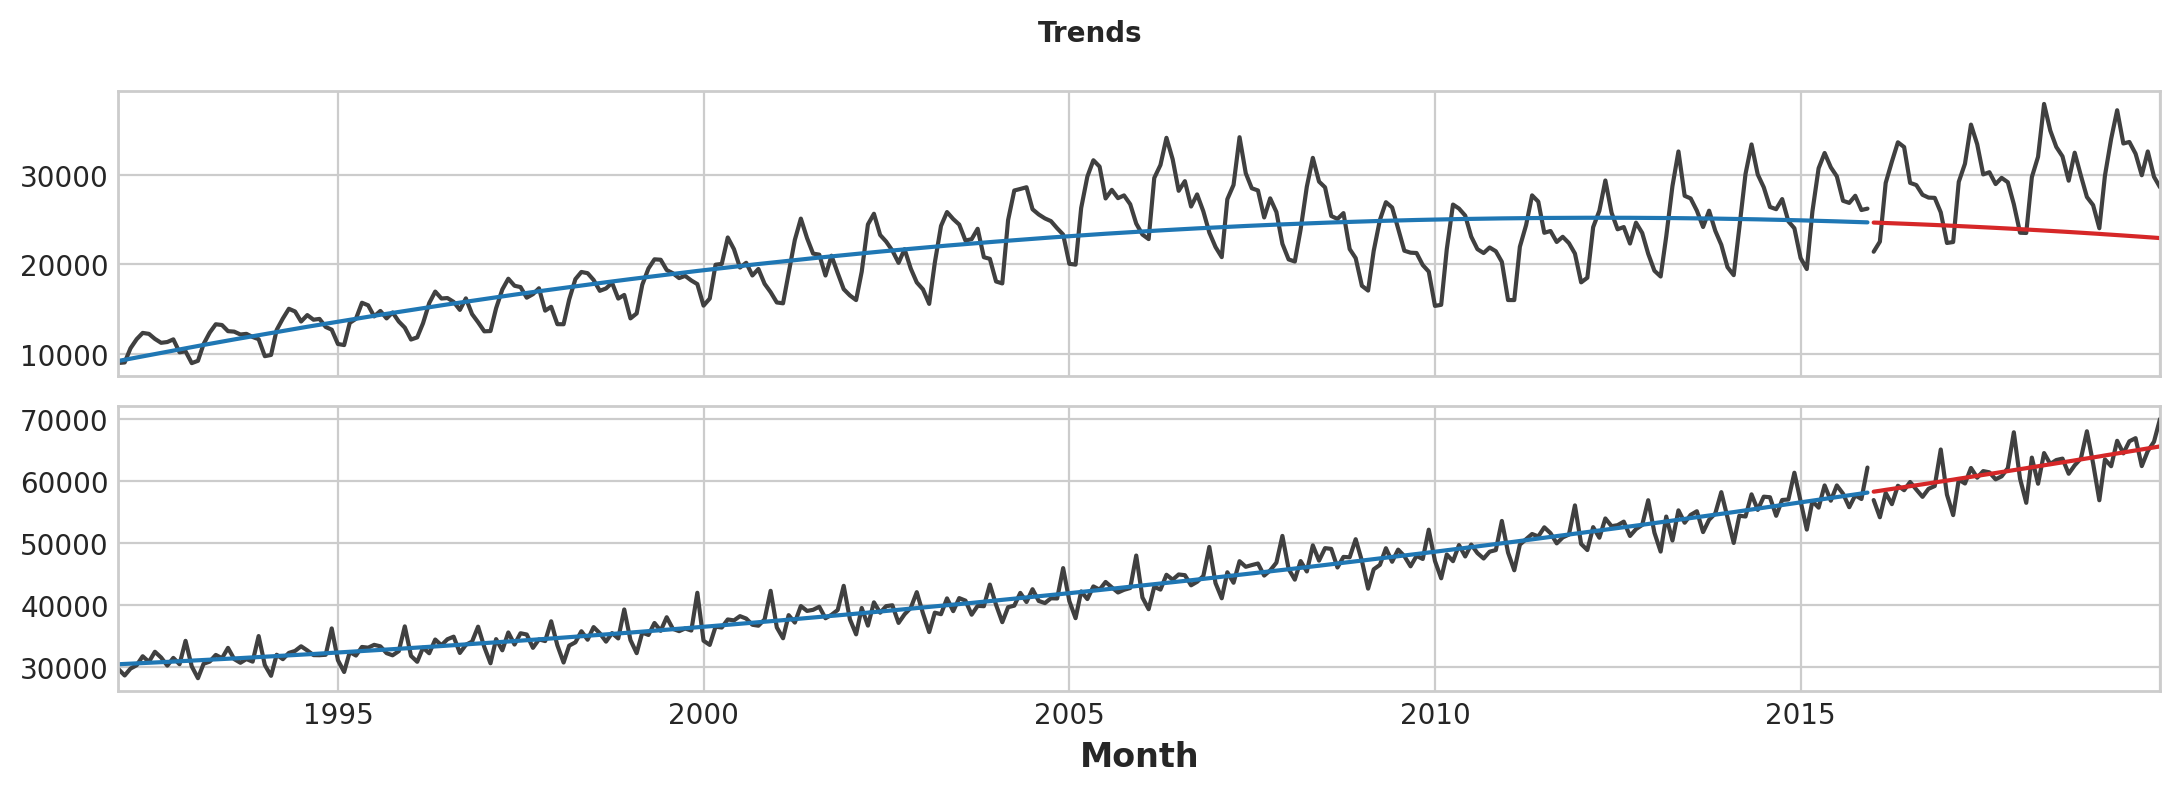

In [70]:
# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

### y.head()

In [71]:
y.index

PeriodIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
             '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
             '1992-09-01', '1992-10-01',
             ...
             '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
             '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
             '2019-11-01', '2019-12-01'],
            dtype='period[D]', name='Month', length=336)

In [72]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [73]:
X.head()

Empty DataFrame
Columns: []
Index: [(1992-01-01, BuildingMaterials), (1992-01-01, FoodAndBeverage), (1992-02-01, BuildingMaterials), (1992-02-01, FoodAndBeverage), (1992-03-01, BuildingMaterials)]

In [74]:
y.head()

Month       Industries       
1992-01-01  BuildingMaterials     8964
            FoodAndBeverage      29589
1992-02-01  BuildingMaterials     9023
            FoodAndBeverage      28570
1992-03-01  BuildingMaterials    10608
Name: Sales, dtype: int64

In [75]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [77]:
X_train.head()

,Industries,Month
Month,,
1992-01-01,0,1
1992-01-01,1,1
1992-02-01,0,2
1992-02-01,1,2
1992-03-01,0,3


In [78]:
X_test.head()

,Industries,Month
Month,,
2016-01-01,0,1
2016-01-01,1,1
2016-02-01,0,2
2016-02-01,1,2
2016-03-01,0,3


In [79]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

In [81]:
y_fit.head()

Month       Industries       
1992-01-01  BuildingMaterials     9192.966040
            FoodAndBeverage      30384.413252
1992-02-01  BuildingMaterials     9324.354900
            FoodAndBeverage      30430.803516
1992-03-01  BuildingMaterials     9455.202650
Name: Sales, dtype: float64

In [82]:
y_pred.head()

Month       Industries       
2016-01-01  BuildingMaterials    24669.950487
            FoodAndBeverage      58283.115113
2016-02-01  BuildingMaterials    24645.499575
            FoodAndBeverage      58430.817613
2016-03-01  BuildingMaterials    24620.507554
Name: Sales, dtype: float64

In [83]:
y_resid.head()

Month       Industries       
1992-01-01  BuildingMaterials    -228.966040
            FoodAndBeverage      -795.413252
1992-02-01  BuildingMaterials    -301.354900
            FoodAndBeverage     -1860.803516
1992-03-01  BuildingMaterials    1152.797350
Name: Sales, dtype: float64

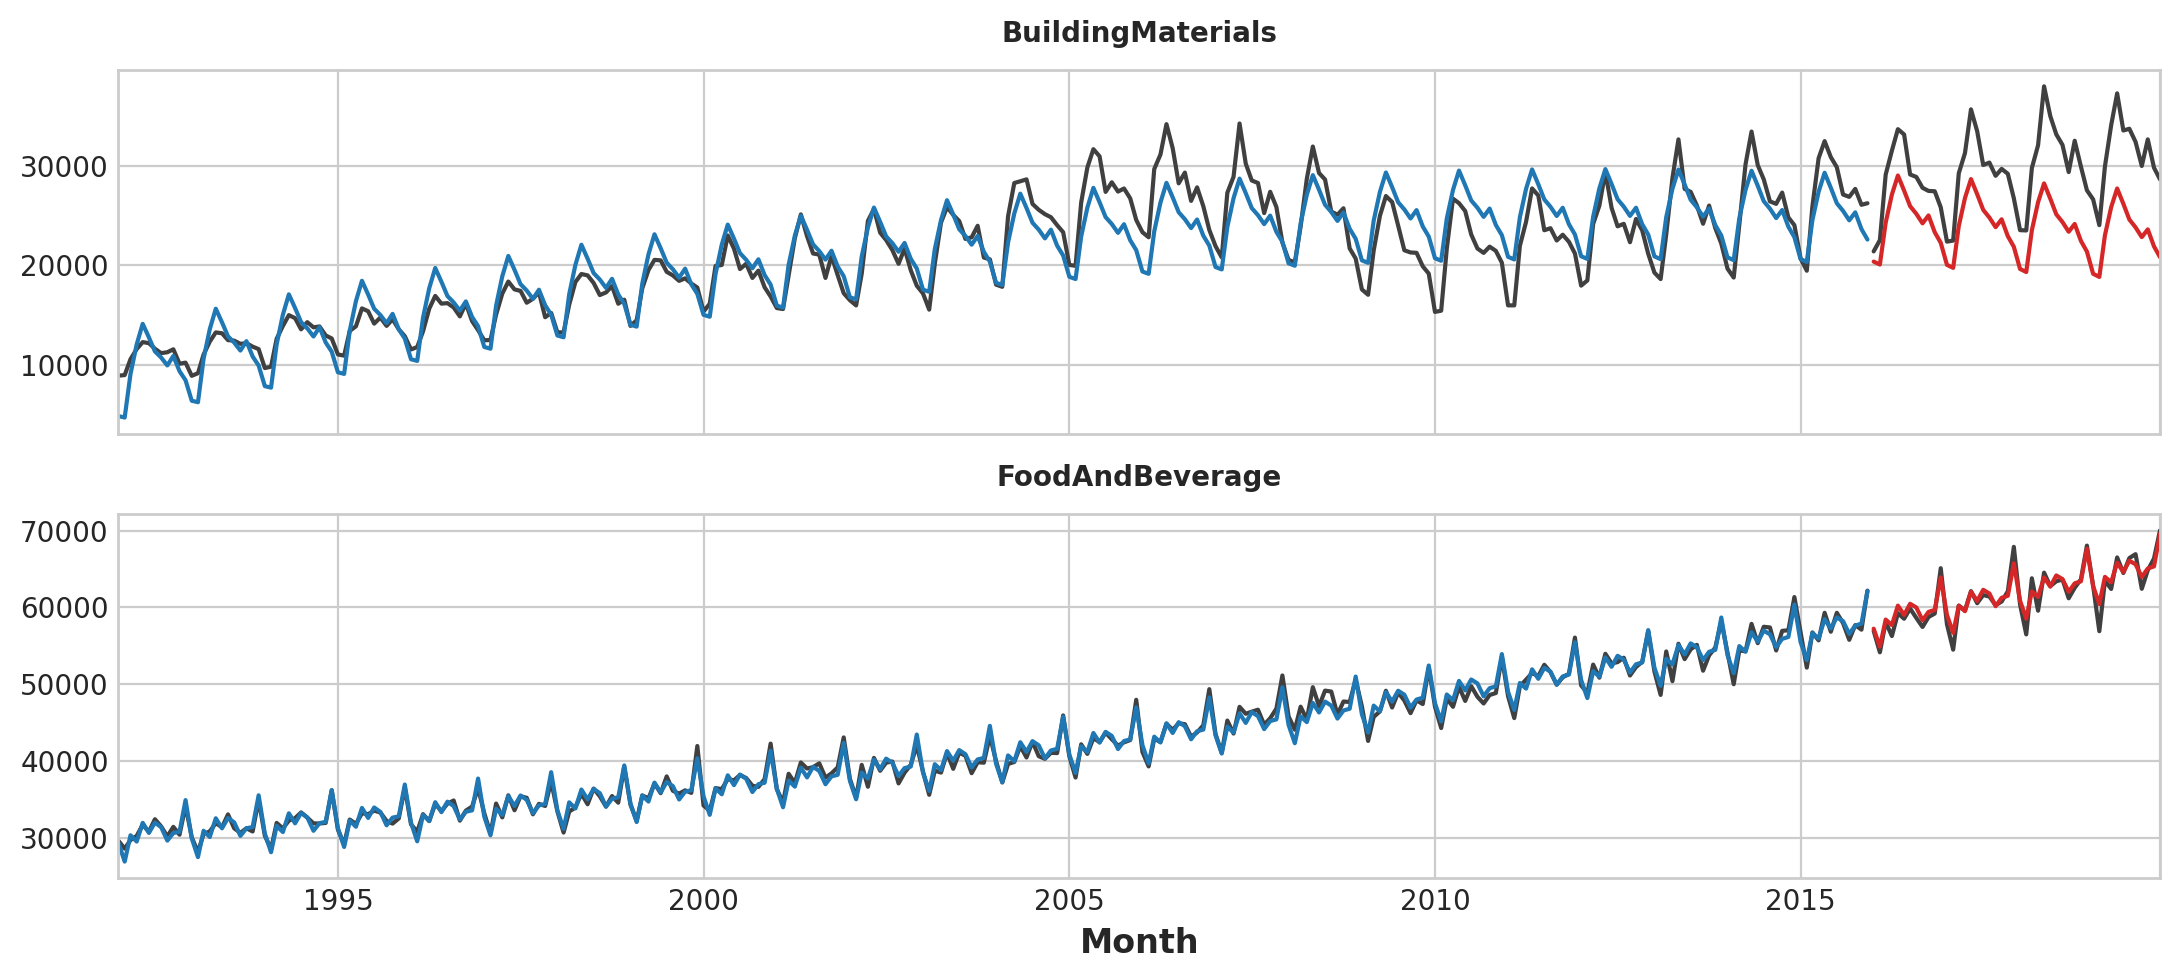

In [80]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])